In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import gym
from gym import spaces
import pickle

In [2]:
class Env_3_Drone_Delivery(gym.Env):
    def __init__(self, grid_size=6, stochastic=False, multiple_deliveries=False):
        super(Env_3_Drone_Delivery, self).__init__()
        
        self.grid_size = grid_size
        self.stochastic = stochastic
        self.multiple_deliveries = multiple_deliveries
        self.actions = ['UP', 'DOWN', 'LEFT', 'RIGHT', 'PICKUP', 'DROPOFF']
        self.no_fly_zones = {(1, 1), (2, 3), (4, 4)}  # no-fly zones
        
        self.action_space = spaces.Discrete(len(self.actions))
        self.observation_space = spaces.Tuple((
            spaces.Discrete(self.grid_size),  # x position
            spaces.Discrete(self.grid_size),  # y position
            spaces.Discrete(2)                # has_package (0 or 1)
        ))
        
        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.drone_position = (0, 0)  # Starting point at the top-left corner (Warehouse)
        self.package_picked = False
        self.delivery_target = (self.grid_size - 1, self.grid_size - 1)  # Customer location (bottom-right corner)
        self.pickup_location = (0, 0)  # Pickup location (Warehouse)
        self.steps_taken = 0
        self.total_reward = 0
        if self.multiple_deliveries:
            self.delivery_count = 0
        
        return self.drone_position + (self.package_picked,), {}

    def step(self, action):
        reward = -1
        new_position = list(self.drone_position[:2])
        
        if action == 0 and self.drone_position[0] > 0:  # UP
            new_position[0] -= 1
        elif action == 1 and self.drone_position[0] < self.grid_size - 1:  # DOWN
            new_position[0] += 1
        elif action == 2 and self.drone_position[1] > 0:  # LEFT
            new_position[1] -= 1
        elif action == 3 and self.drone_position[1] < self.grid_size - 1:  # RIGHT
            new_position[1] += 1

        if self.stochastic and random.random() < 0.1:  # 10% chance of deviation
            new_position = self._applying_stochastic_conditions(new_position)
        
        new_position = tuple(new_position)
        if new_position in self.no_fly_zones:
            reward = -20
        else:
            self.drone_position = new_position

        if action == 4 and self.drone_position == self.pickup_location and not self.package_picked:
            self.package_picked = True
            reward += 10  # Reward for picking up the package

        terminated = False
        if action == 5 and self.drone_position == self.delivery_target and self.package_picked:
            reward = 20
            self.package_picked = False
            if self.multiple_deliveries:
                self.delivery_count += 1
                self._generating_new_targets()
            else:
                terminated = True

        self.steps_taken += 1
        self.total_reward += reward
        truncated = self.steps_taken >= 100  # Arbitrary step limit
        
        return self.drone_position + (self.package_picked,), reward, terminated, truncated, {}

    def render(self):
        grid = np.zeros((self.grid_size, self.grid_size, 3))  # RGB grid
        fig, ax = plt.subplots()
        drone_empty = mpimg.imread("drone_empty.jpg")
        drone_loaded = mpimg.imread("drone_loaded.jpg")
        warehouse = mpimg.imread("warehouse.jpg")
        customer = mpimg.imread("customer.jpg")
        no_fly_zone = mpimg.imread("no_fly_zone.jpg")
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                if (i, j) in self.no_fly_zones:
                    ax.imshow(no_fly_zone, extent=[j, j + 1, self.grid_size - i - 1, self.grid_size - i])
                if (i, j) == self.pickup_location:
                    ax.imshow(warehouse, extent=[j, j + 1, self.grid_size - i - 1, self.grid_size - i])
                if (i, j) == self.delivery_target:
                    ax.imshow(customer, extent=[j, j + 1, self.grid_size - i - 1, self.grid_size - i])
    
        if self.package_picked:
            ax.imshow(drone_loaded, extent=[self.drone_position[1], self.drone_position[1] + 1, 
                                            self.grid_size - self.drone_position[0] - 1, 
                                            self.grid_size - self.drone_position[0]])
        else:
            ax.imshow(drone_empty, extent=[self.drone_position[1], self.drone_position[1] + 1, 
                                        self.grid_size - self.drone_position[0] - 1, 
                                        self.grid_size - self.drone_position[0]])
        
        ax.set_xticks(range(self.grid_size + 1))
        ax.set_yticks(range(self.grid_size + 1))
        ax.grid(True, which='both', color='black', linestyle='-', linewidth=1)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.show()

    def _applying_stochastic_conditions(self, position):
        deviations = [(0, 1), (1, 0), (0, -1), (-1, 0)]
        deviation = random.choice(deviations)
        new_position = (position[0] + deviation[0], position[1] + deviation[1])
        return tuple(max(0, min(self.grid_size - 1, x)) for x in new_position)

    def _generating_new_targets(self):
        self.delivery_target = (random.randint(0, self.grid_size - 1), random.randint(0, self.grid_size - 1))
        while self.delivery_target in self.no_fly_zones:
            self.delivery_target = (random.randint(0, self.grid_size - 1), random.randint(0, self.grid_size - 1))
        self.pickup_location = (random.randint(0, self.grid_size - 1), random.randint(0, self.grid_size - 1))
        while self.pickup_location in self.no_fly_zones or self.pickup_location == self.delivery_target:
            self.pickup_location = (random.randint(0, self.grid_size - 1), random.randint(0, self.grid_size - 1))

In [3]:
def train_q_learning(env, episodes=500, alpha=0.1, gamma=0.9, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
    q_table = np.zeros((env.grid_size, env.grid_size, 2, len(env.actions)))
    rewards_per_episode = []
    epsilons = []
    
    print("Initial Q-Table:")
    print(q_table)
    
    for episode in range(episodes):
        state, _ = env.reset()
        state_index = (state[0], state[1], int(state[2]))
        total_reward = 0
        done = False
        truncated = False
        
        while not done and not truncated:
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[state_index])
            
            next_state, reward, done, truncated, _ = env.step(action)
            next_state_index = (next_state[0], next_state[1], int(next_state[2]))
            
            # Q-learning update rule
            q_table[state_index][action] = (1 - alpha) * q_table[state_index][action] + \
                                           alpha * (reward + gamma * np.max(q_table[next_state_index]))
            
            state_index = next_state_index
            total_reward += reward
        
        rewards_per_episode.append(total_reward)
        epsilons.append(epsilon)
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
    
    print("Trained Q-Table:")
    print(q_table)
    
    return q_table, rewards_per_episode, epsilons

def evaluate_q_learning(env, q_table, episodes=10):
    rewards_per_episode = []
    
    for _ in range(episodes):
        state, _ = env.reset()
        state_index = (state[0], state[1], int(state[2]))
        total_reward = 0
        done = False
        truncated = False
        
        while not done and not truncated:
            action = np.argmax(q_table[state_index])
            next_state, reward, done, truncated, _ = env.step(action)
            next_state_index = (next_state[0], next_state[1], int(next_state[2]))
            
            state_index = next_state_index
            total_reward += reward

        rewards_per_episode.append(total_reward)
    
    return rewards_per_episode

Initial Q-Table:
[[[[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]]


 [[[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]]


 [[[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]]


 [[[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0

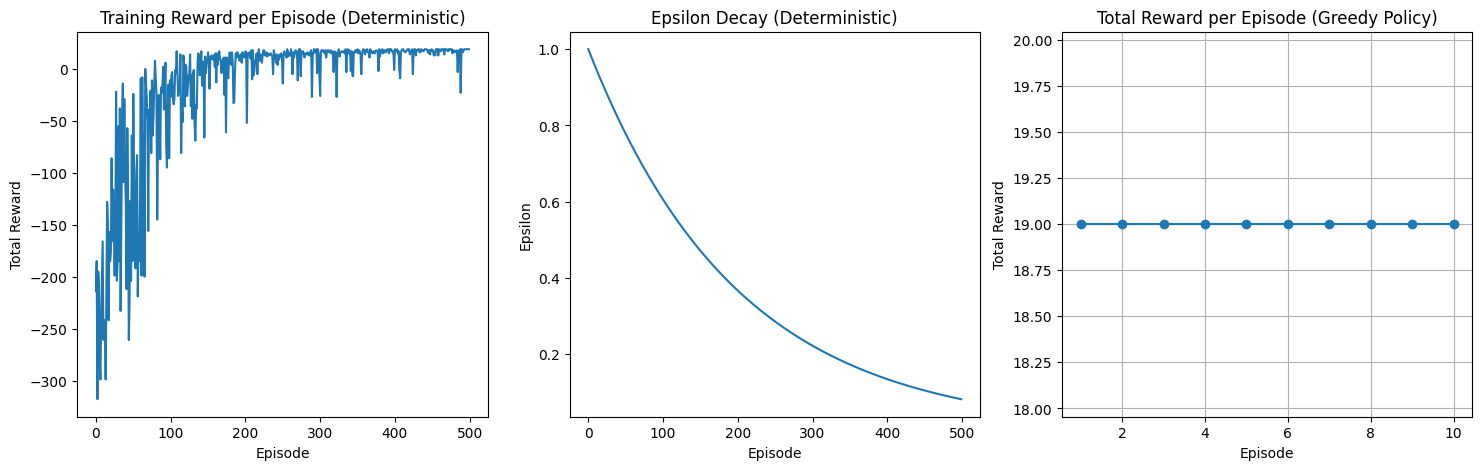

In [5]:
# Training deterministic environment
env_deterministic = Env_3_Drone_Delivery(stochastic=False, multiple_deliveries=False)
q_table_det, rewards_det, epsilons_det = train_q_learning(env_deterministic)

# Save the trained Q-table
with open("q_table_deterministic.pkl", "wb") as f:
    pickle.dump(q_table_det, f)

# Evaluate deterministic environment
eval_rewards_det = evaluate_q_learning(env_deterministic, q_table_det)

plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.plot(rewards_det)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Reward per Episode (Deterministic)")

plt.subplot(1, 3, 2)
plt.plot(epsilons_det)
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.title("Epsilon Decay (Deterministic)")

plt.subplot(1, 3, 3)
plt.plot(range(1, 11), eval_rewards_det, marker='o', linestyle='-')
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward per Episode (Greedy Policy)")
plt.grid(True)
plt.show()

Initial Q-Table:
[[[[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]]


 [[[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]]


 [[[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]]


 [[[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0

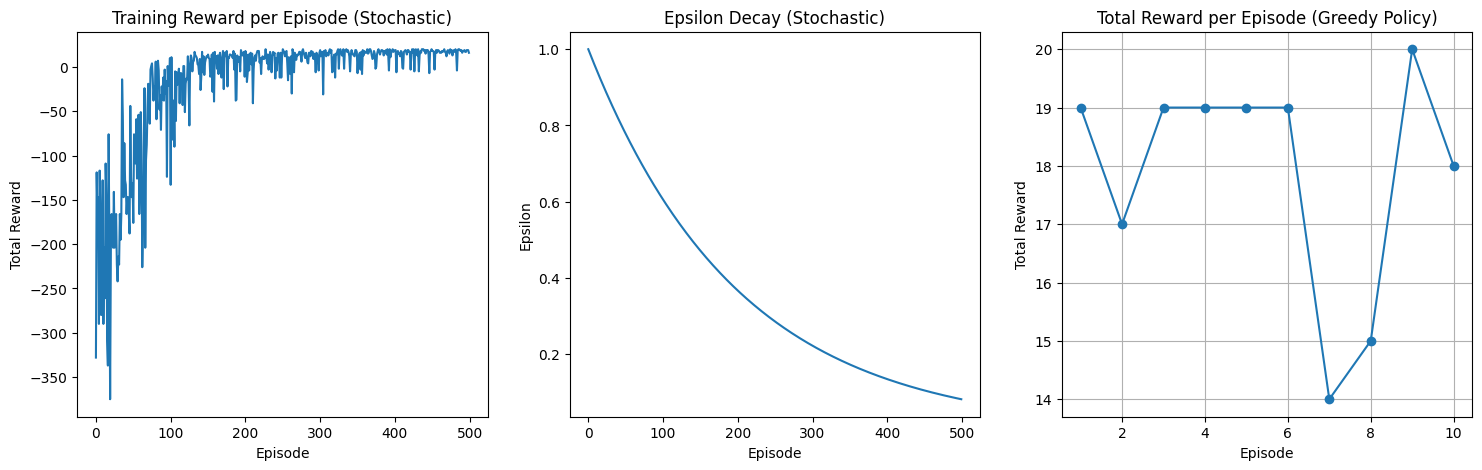

In [6]:
# Training stochastic environment
env_stochastic = Env_3_Drone_Delivery(stochastic=True, multiple_deliveries=False)
q_table_stoch, rewards_stoch, epsilons_stoch = train_q_learning(env_stochastic)

with open("q_table_stochastic.pkl", "wb") as f:
    pickle.dump(q_table_stoch, f)

eval_rewards_stoch = evaluate_q_learning(env_stochastic, q_table_stoch)

# Plot results
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.plot(rewards_stoch)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Reward per Episode (Stochastic)")

plt.subplot(1, 3, 2)
plt.plot(epsilons_stoch)
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.title("Epsilon Decay (Stochastic)")

plt.subplot(1, 3, 3)
plt.plot(range(1, 11), eval_rewards_stoch, marker='o', linestyle='-')
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward per Episode (Greedy Policy)")
plt.grid(True)
plt.show()

### Hyper parameters tuning for Deterministic Environment

Initial Q-Table:
[[[[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]]


 [[[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]]


 [[[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]]


 [[[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0

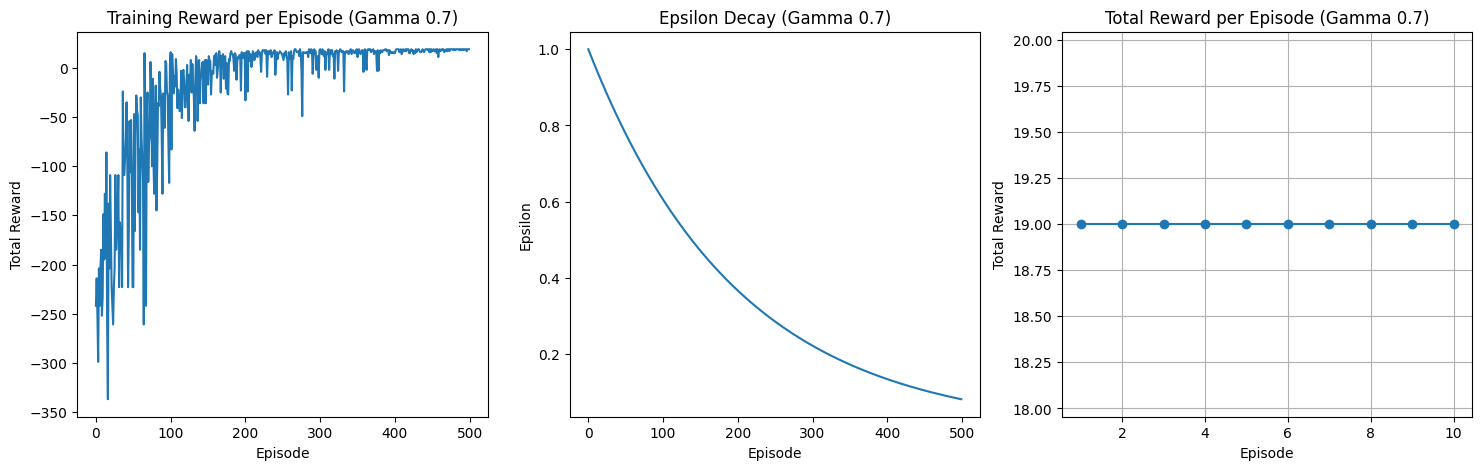

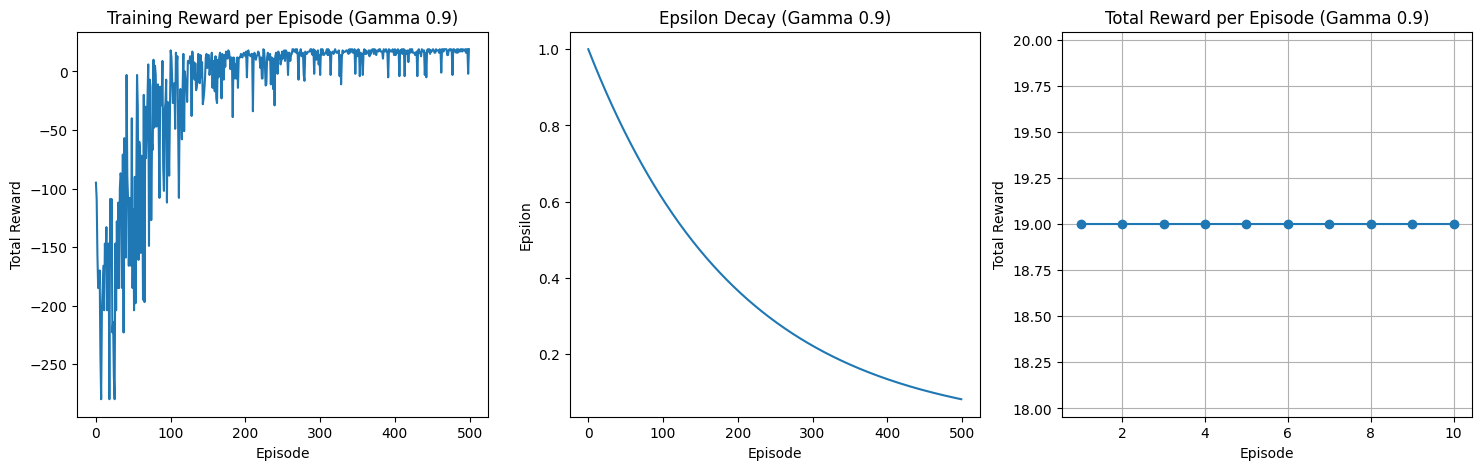

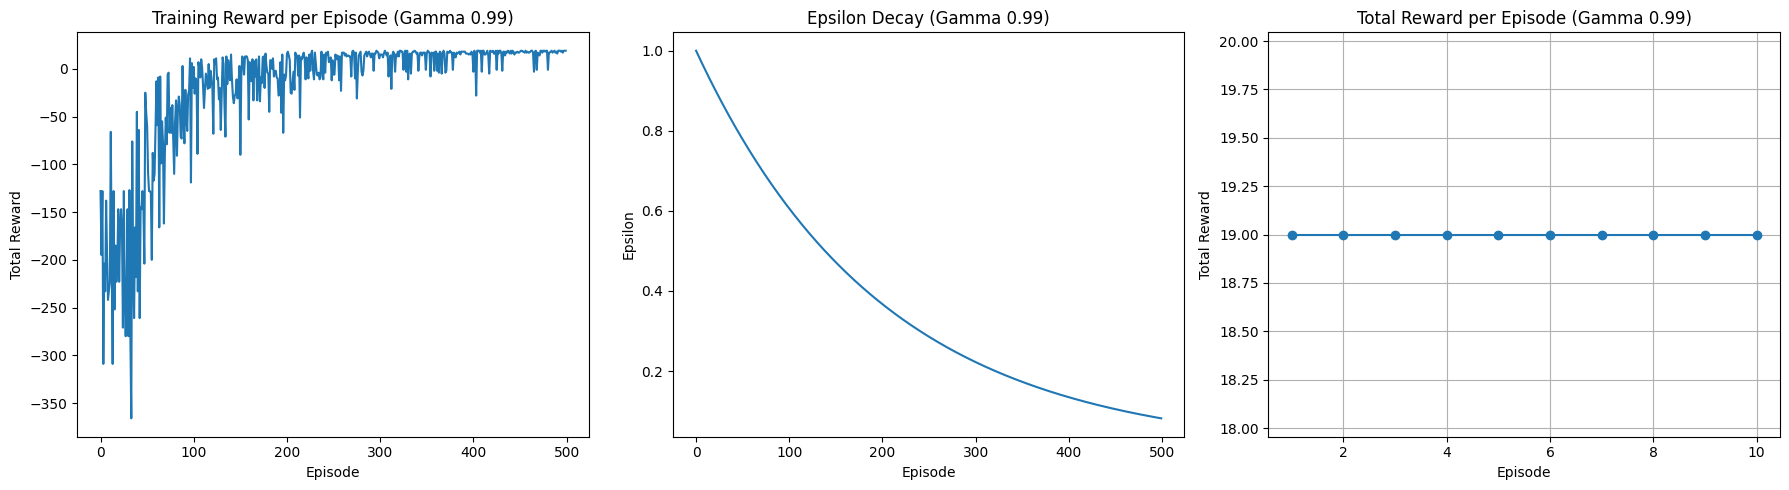

Initial Q-Table:
[[[[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]]


 [[[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]]


 [[[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]]


 [[[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0

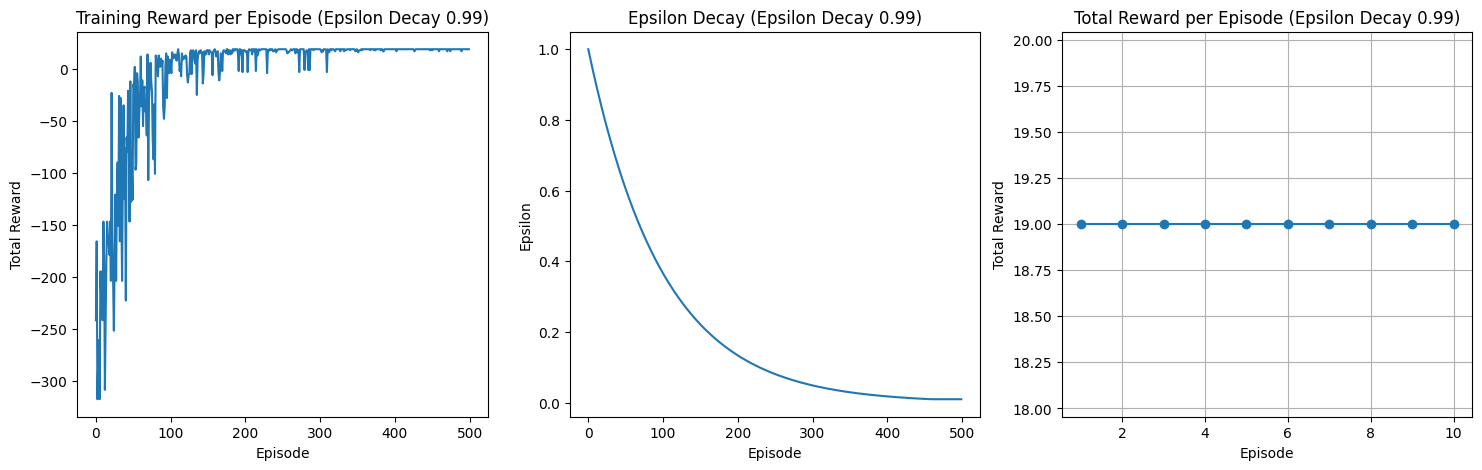

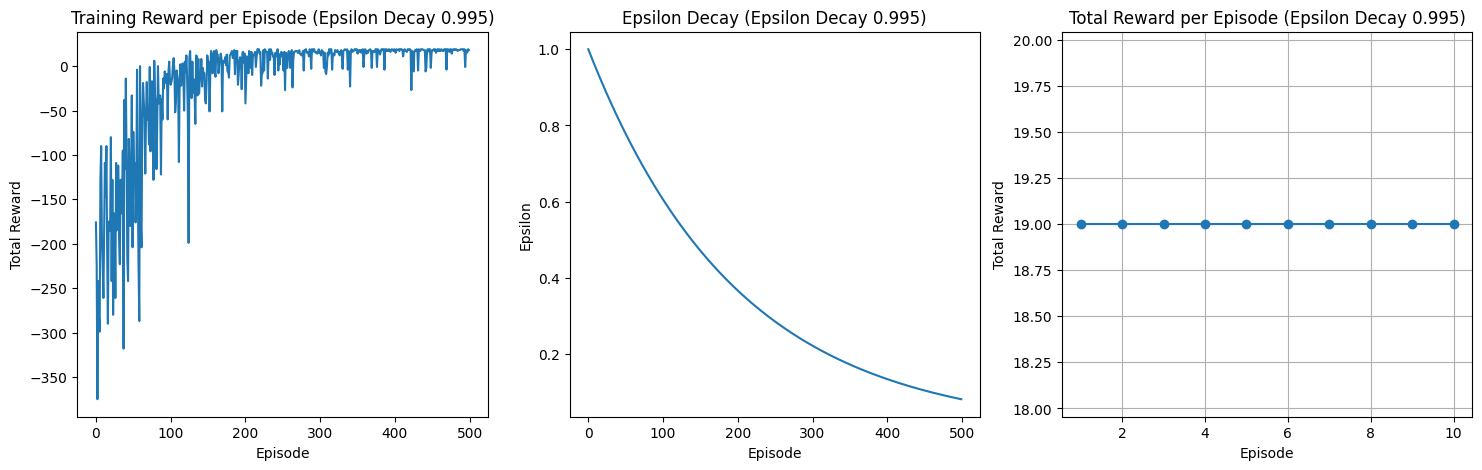

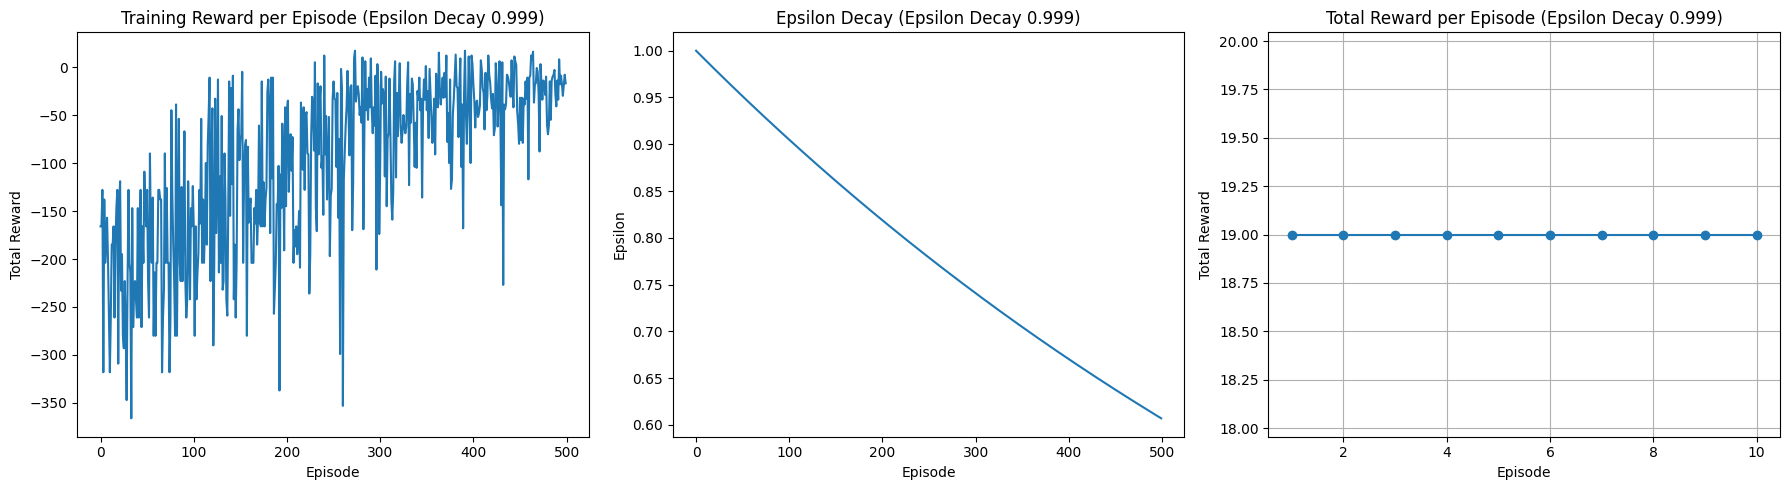

In [7]:
env_deterministic = Env_3_Drone_Delivery(stochastic=False, multiple_deliveries=False)

# Hyperparameter tuning - Discount factor (gamma)
gamma_values = [0.7, 0.9, 0.99]
gamma_results = {}

for gamma in gamma_values:
    q_table, rewards, epsilons = train_q_learning(env_deterministic, gamma=gamma)
    eval_rewards = evaluate_q_learning(env_deterministic, q_table)
    gamma_results[gamma] = eval_rewards
    plt.figure(figsize=(18, 5))
    plt.subplot(1, 3, 1)
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title(f"Training Reward per Episode (Gamma {gamma})")

    plt.subplot(1, 3, 2)
    plt.plot(epsilons)
    plt.xlabel("Episode")
    plt.ylabel("Epsilon")
    plt.title(f"Epsilon Decay (Gamma {gamma})")

    plt.subplot(1, 3, 3)
    plt.plot(range(1, 11), eval_rewards, marker='o', linestyle='-')
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title(f"Total Reward per Episode (Gamma {gamma})")
    plt.grid(True)
plt.tight_layout()
plt.show()

# Hyperparameter tuning - Epsilon decay
epsilon_decay_values = [0.99, 0.995, 0.999]
epsilon_results = {}

for decay in epsilon_decay_values:
    q_table, rewards, epsilons = train_q_learning(env_deterministic, epsilon_decay=decay)
    eval_rewards = evaluate_q_learning(env_deterministic, q_table)
    epsilon_results[decay] = eval_rewards
    plt.figure(figsize=(18, 5))
    plt.subplot(1, 3, 1)
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title(f"Training Reward per Episode (Epsilon Decay {decay})")

    plt.subplot(1, 3, 2)
    plt.plot(epsilons)
    plt.xlabel("Episode")
    plt.ylabel("Epsilon")
    plt.title(f"Epsilon Decay (Epsilon Decay {decay})")

    plt.subplot(1, 3, 3)
    plt.plot(range(1, 11), eval_rewards, marker='o', linestyle='-')
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title(f"Total Reward per Episode (Epsilon Decay {decay})")
    plt.grid(True)
plt.tight_layout()
plt.show()

### Hyper parameters tuning for Stochastic Environment

Initial Q-Table:
[[[[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]]


 [[[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]]


 [[[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]]


 [[[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0

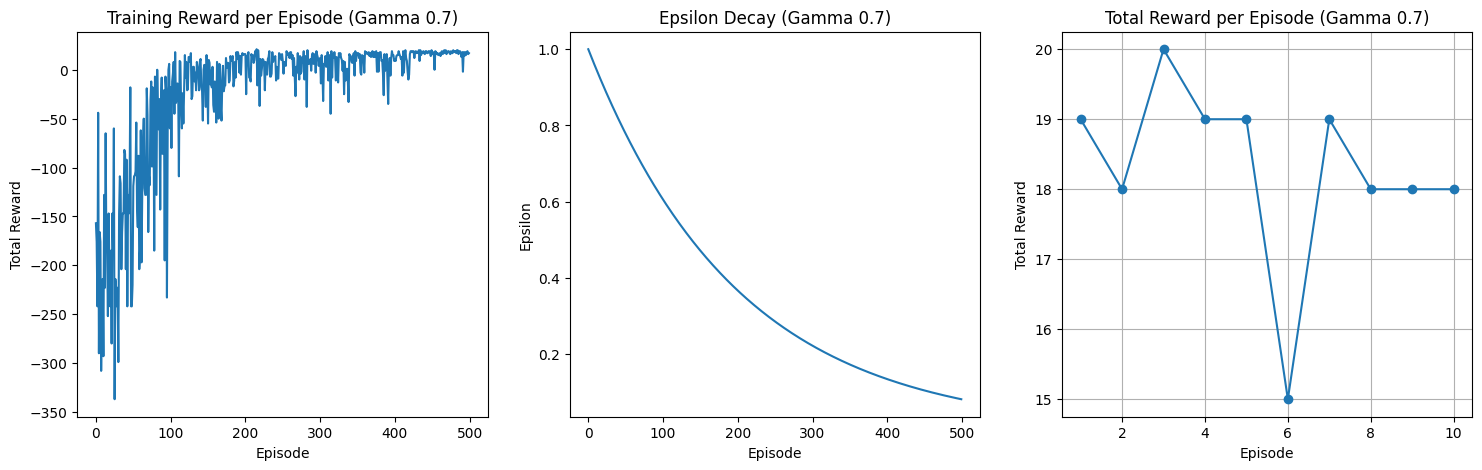

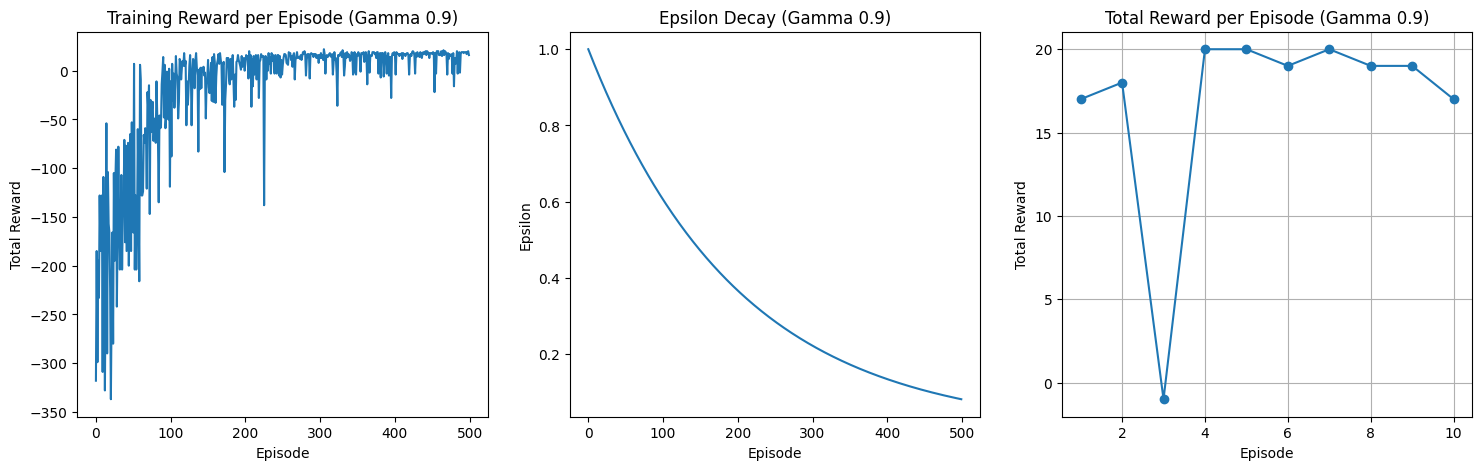

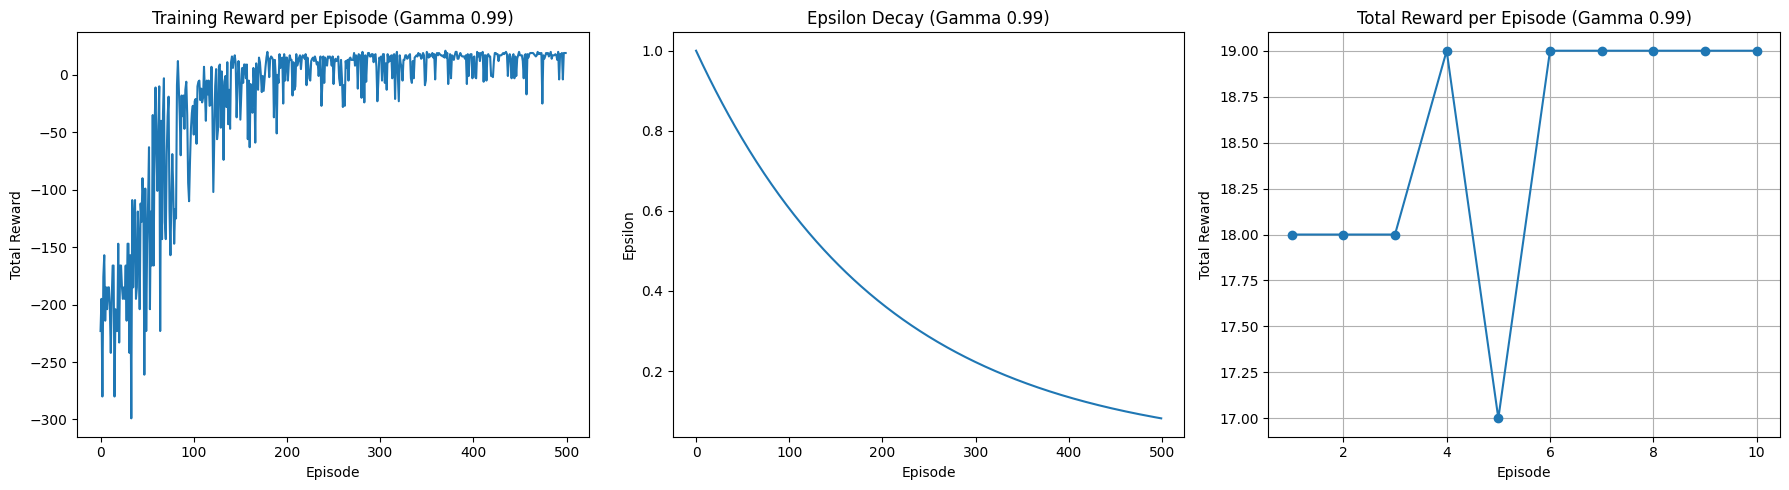

Initial Q-Table:
[[[[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]]


 [[[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]]


 [[[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]]


 [[[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0

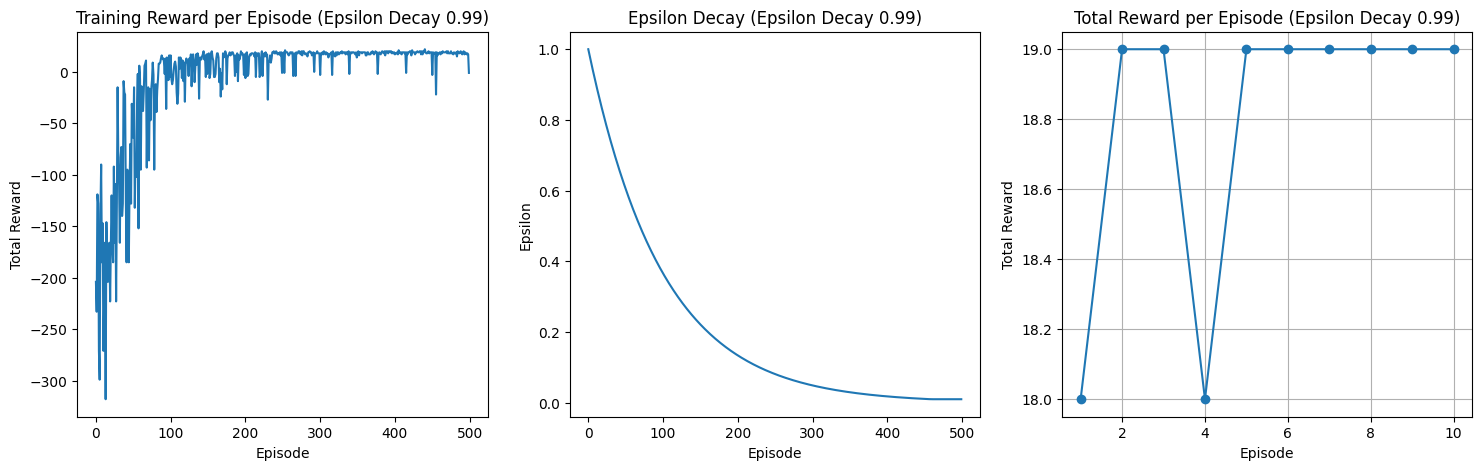

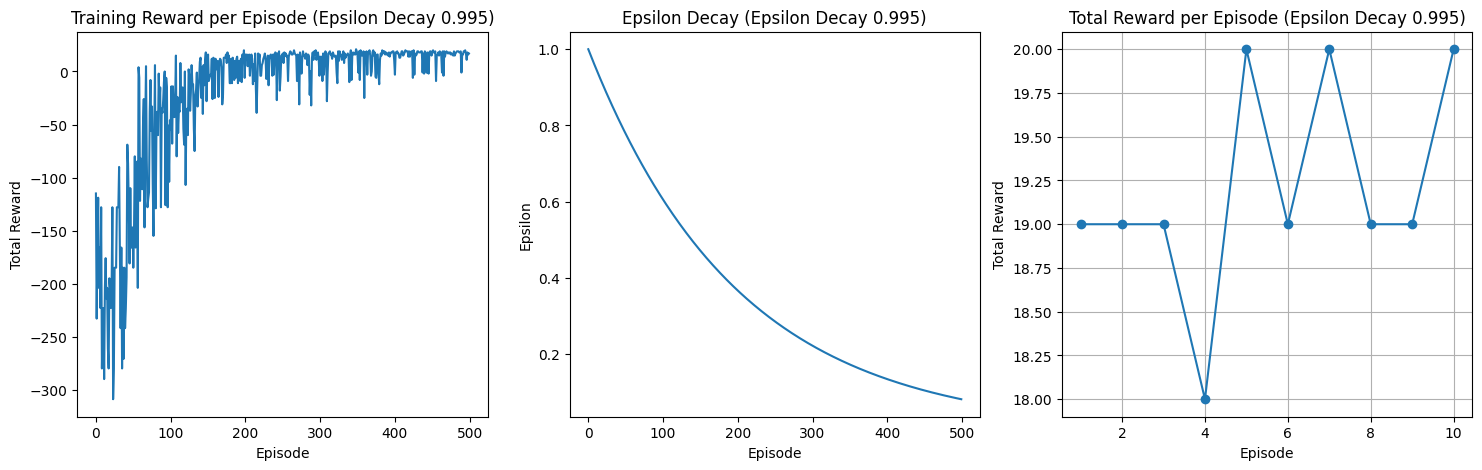

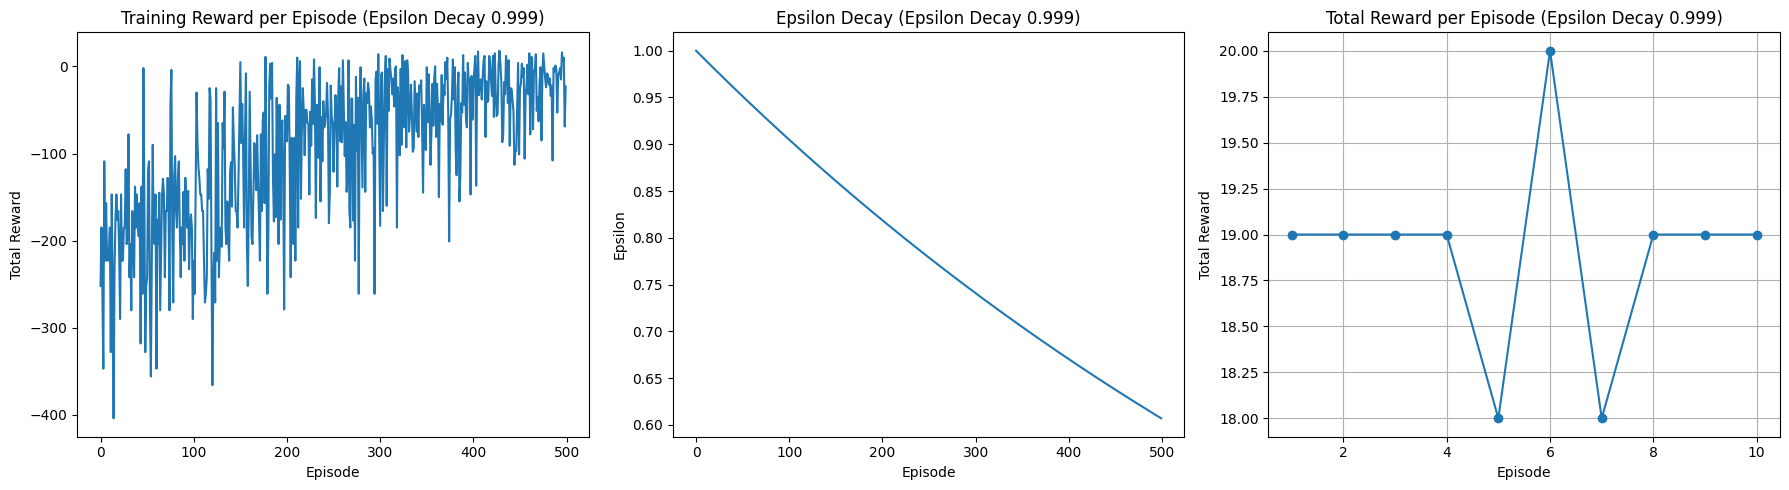

In [8]:
env_stochastic = Env_3_Drone_Delivery(stochastic=True, multiple_deliveries=False)

# Hyperparameter tuning - Discount factor (gamma)
gamma_values = [0.7, 0.9, 0.99]
gamma_results = {}

for gamma in gamma_values:
    q_table, rewards, epsilons = train_q_learning(env_stochastic, gamma=gamma)
    eval_rewards = evaluate_q_learning(env_stochastic, q_table)
    gamma_results[gamma] = eval_rewards
    plt.figure(figsize=(18, 5))
    plt.subplot(1, 3, 1)
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title(f"Training Reward per Episode (Gamma {gamma})")

    plt.subplot(1, 3, 2)
    plt.plot(epsilons)
    plt.xlabel("Episode")
    plt.ylabel("Epsilon")
    plt.title(f"Epsilon Decay (Gamma {gamma})")

    plt.subplot(1, 3, 3)
    plt.plot(range(1, 11), eval_rewards, marker='o', linestyle='-')
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title(f"Total Reward per Episode (Gamma {gamma})")
    plt.grid(True)
plt.tight_layout()
plt.show()

# Hyperparameter tuning - Epsilon decay
epsilon_decay_values = [0.99, 0.995, 0.999]
epsilon_results = {}

for decay in epsilon_decay_values:
    q_table, rewards, epsilons = train_q_learning(env_stochastic, epsilon_decay=decay)
    eval_rewards = evaluate_q_learning(env_stochastic, q_table)
    epsilon_results[decay] = eval_rewards
    plt.figure(figsize=(18, 5))
    plt.subplot(1, 3, 1)
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title(f"Training Reward per Episode (Epsilon Decay {decay})")

    plt.subplot(1, 3, 2)
    plt.plot(epsilons)
    plt.xlabel("Episode")
    plt.ylabel("Epsilon")
    plt.title(f"Epsilon Decay (Epsilon Decay {decay})")

    plt.subplot(1, 3, 3)
    plt.plot(range(1, 11), eval_rewards, marker='o', linestyle='-')
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title(f"Total Reward per Episode (Epsilon Decay {decay})")
    plt.grid(True)
plt.tight_layout()
plt.show()

### Implementing SARSA on Deterministic and Stochastic environments

In [9]:
def state_to_index(state, grid_size):
    x, y, has_package = state
    return (x * grid_size + y) * 2 + has_package

# Define SARSA training function
def train_sarsa(env, episodes=500, alpha=0.1, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, min_epsilon=0.01):
    num_states = env.grid_size * env.grid_size * 2
    num_actions = env.action_space.n
    q_table = np.zeros((num_states, num_actions))

    rewards_per_episode = []
    epsilons = []

    for episode in range(episodes):
        epsilon = max(min_epsilon, epsilon * epsilon_decay)
        state, _ = env.reset()
        state_index = state_to_index(state, env.grid_size)
        action = np.random.choice(num_actions) if random.uniform(0, 1) < epsilon else np.argmax(q_table[state_index])
        total_reward = 0
        done = False
        truncated = False

        while not done and not truncated:
            next_state, reward, done, truncated, _ = env.step(action)
            next_state_index = state_to_index(next_state, env.grid_size)
            next_action = np.random.choice(num_actions) if random.uniform(0, 1) < epsilon else np.argmax(q_table[next_state_index])

            # SARSA update rule
            q_table[state_index, action] += alpha * (reward + gamma * q_table[next_state_index, next_action] - q_table[state_index, action])

            state_index = next_state_index
            action = next_action
            total_reward += reward

        rewards_per_episode.append(total_reward)
        epsilons.append(epsilon)

    return q_table, rewards_per_episode, epsilons

# greedy evaluation function
def evaluate_greedy(env, q_table, episodes=10):
    rewards = []

    for episode in range(episodes):
        state, _ = env.reset()
        state_index = state_to_index(state, env.grid_size)
        total_reward = 0
        done = False
        truncated = False

        while not done and not truncated:
            action = np.argmax(q_table[state_index])  # Always pick the best action
            state, reward, done, truncated, _ = env.step(action)
            state_index = state_to_index(state, env.grid_size)
            total_reward += reward

        rewards.append(total_reward)

    return rewards


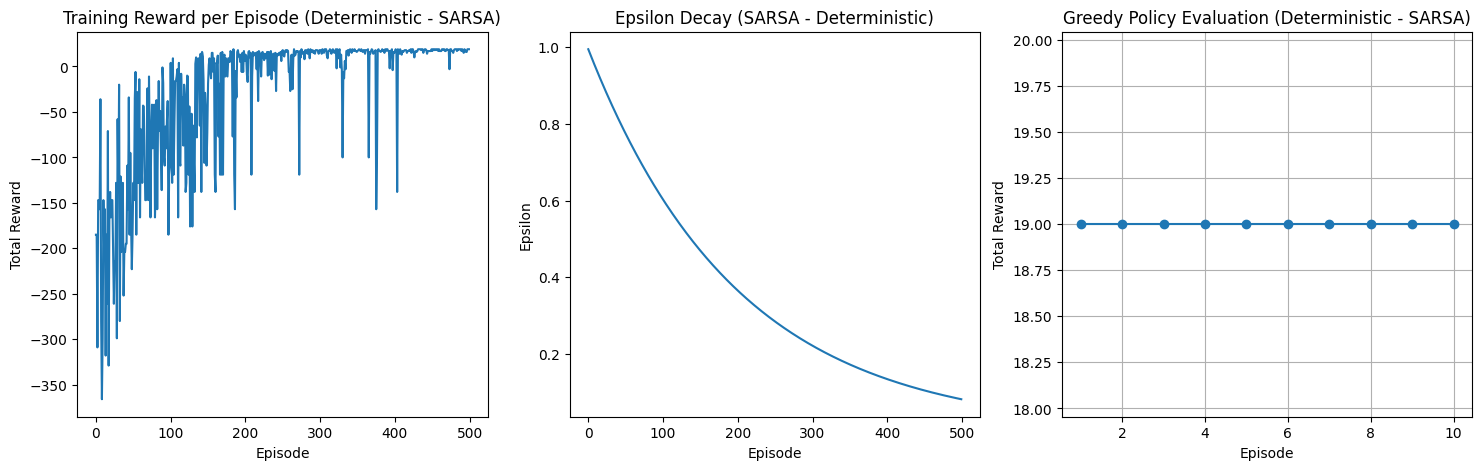

In [10]:
# Implmenting Sarsa on Deterministic environment
env_deterministic = Env_3_Drone_Delivery(stochastic=False, multiple_deliveries=False)
sarsa_q_table_det, sarsa_rewards_det, sarsa_epsilons_det = train_sarsa(env_deterministic)
sarsa_greedy_rewards_det = evaluate_greedy(env_deterministic, sarsa_q_table_det)

with open("q_table_sarsa_deterministic.pkl", "wb") as f:
    pickle.dump(sarsa_q_table_det, f)

plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.plot(sarsa_rewards_det)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Reward per Episode (Deterministic - SARSA)")

plt.subplot(1, 3, 2)
plt.plot(sarsa_epsilons_det)
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.title("Epsilon Decay (SARSA - Deterministic)")

plt.subplot(1, 3, 3)
plt.plot(range(1, 11), sarsa_greedy_rewards_det, marker='o', linestyle='-')
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Greedy Policy Evaluation (Deterministic - SARSA)")
plt.grid(True)
plt.show()

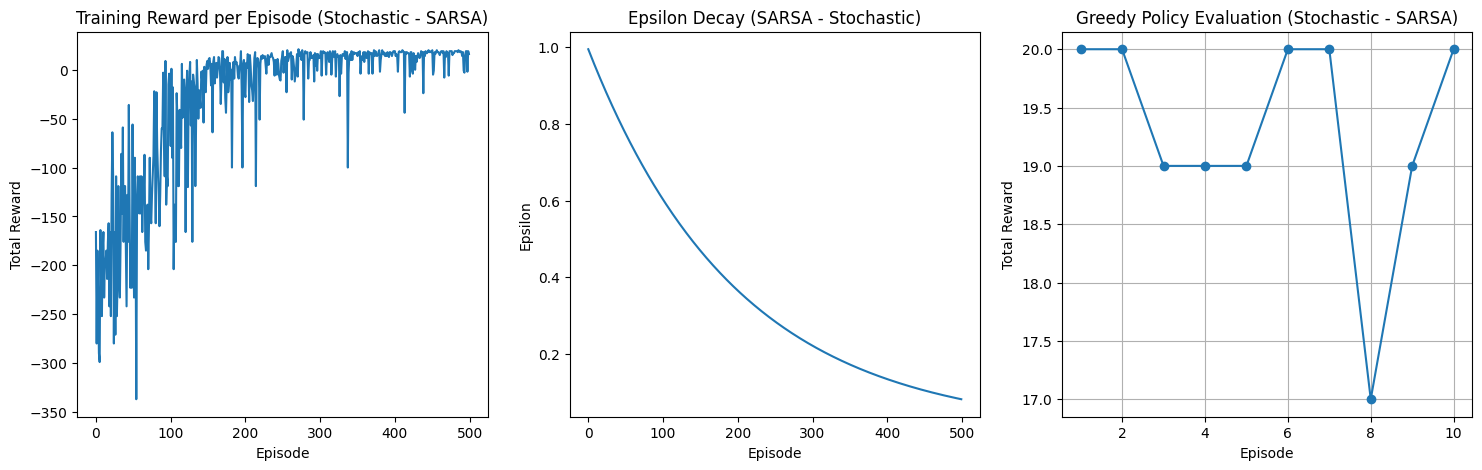

In [11]:
# Implmenting Sarsa on Stochastic environment
env_stochastic = Env_3_Drone_Delivery(stochastic=True, multiple_deliveries=False)
sarsa_q_table_stoch, sarsa_rewards_stoch, sarsa_epsilons_stoch = train_sarsa(env_stochastic)
sarsa_greedy_rewards_det = evaluate_greedy(env_stochastic, sarsa_q_table_stoch)

with open("q_table_sarsa_stochastic.pkl", "wb") as f:
    pickle.dump(sarsa_q_table_stoch, f)

plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.plot(sarsa_rewards_stoch)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Reward per Episode (Stochastic - SARSA)")

plt.subplot(1, 3, 2)
plt.plot(sarsa_epsilons_stoch)
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.title("Epsilon Decay (SARSA - Stochastic)")

plt.subplot(1, 3, 3)
plt.plot(range(1, 11), sarsa_greedy_rewards_det, marker='o', linestyle='-')
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Greedy Policy Evaluation (Stochastic - SARSA)")
plt.grid(True)
plt.show()